In [147]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from dataclasses import dataclass
from typing import Any, List, Sequence, Tuple
from telesketch.envs.discrete_telesketch import DiscreteTelesketchEnv

import gymnasium as gym
import torch.distributions as tp
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim


In [146]:
# Ref canvas
IMG_SIZE = 64
PATCH_SIZE = 11
ref_canvas = np.full((IMG_SIZE, IMG_SIZE, 3), 255, dtype=np.uint8)
ref_canvas = cv2.line(ref_canvas, (0, 0), (32, 32), (0, 0, 0), 2)
ref_canvas = cv2.line(ref_canvas, (32, 32), (64, 32), (0, 0, 0), 2)

rmse = lambda x, y: np.sum((x - y) ** 2)
env = DiscreteTelesketchEnv(ref_canvas, 
                            rmse,
                            lambda sim: sim < 5,
                            5, 2, 
                            patch_size=(PATCH_SIZE, PATCH_SIZE), 
                            render_mode="image"
)

In [154]:
class PicassoModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        # Global model
        self.global_model = nn.Sequential(
            nn.Conv2d(2, 32, 8, 4),
            nn.Mish(),
            nn.Conv2d(32, 64, 4, 2),
            nn.Mish(),
            nn.Conv2d(64, 64, 3),
            nn.Flatten()
        )

        # Local model
        self.local_model = nn.Sequential(
            nn.Conv2d(2, 64, 8),
            nn.Mish(),
            nn.Flatten()
        )

    def forward(self, state):
        # Stack inputs as channels
        global_input_np = np.stack([state["ref"], state["cnv"]])
        local_input_np = np.stack([state["ref_patch"], state["cnv_patch"]])

        # Add extra dimension for batch
        global_input = torch.from_numpy(global_input_np).unsqueeze(0)
        local_input = torch.from_numpy(local_input_np).unsqueeze(0)

        # Concatenate layers outputs
        X = torch.cat([
            self.global_model(global_input),
            self.local_model(local_input)
        ], dim=1)

        # Get heads output
        actor_out = nn.Linear(X.size(1), 8)(X)
        critic_out = nn.Linear(X.size(1), 1)(X)

        # Make categorical distribution
        dist = tp.Categorical(logits=actor_out)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action, log_prob, critic_out.squeeze(0)


In [142]:
state, _ = env.reset()

(tensor([0]), tensor([-1.9409], grad_fn=<SqueezeBackward1>), tensor([0.0850], grad_fn=<SqueezeBackward1>))


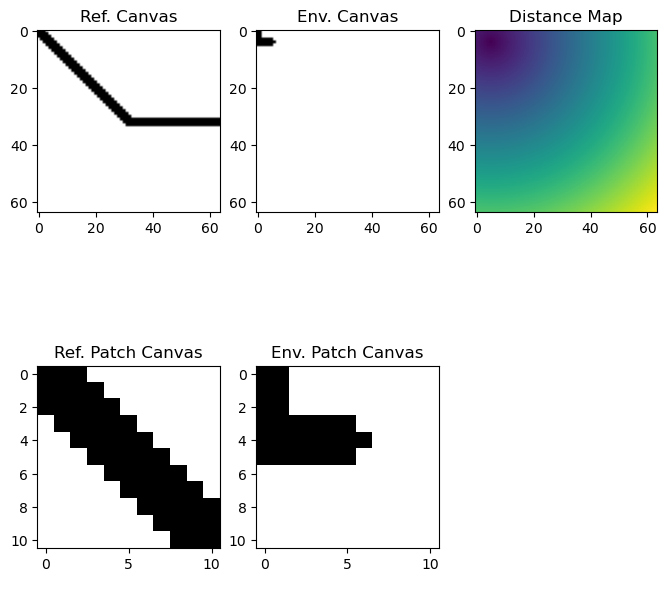

In [145]:
model = PicassoModel()

y = model(state)

print(y)
env.step(y[0])
env.render()

In [ ]:
def compute_loss(log_probs: tf.Tensor, values: tf.Tensor, returns: tf.Tensor, critic_weight=1, entropy_weight=1) -> tf.Tensor:
    adv = returns - values

    # Actor loss
    actor_loss = -tf.math.reduce_sum(log_probs * adv)

    # Entropy loss
    entropy_loss = -tf.math.reduce_sum(log_probs * tf.math.exp(log_probs))

    # Critic loss
    # Use hubber loss because it's more stable to outliers than delta^2
    critic_loss = HUBER_LOSS(values, returns)

    return actor_loss + critic_loss * critic_weight - entropy_weight * entropy_loss

In [ ]:
def compute_returns(r: torch.FloatTensor, gamma: float) -> torch.FloatTensor:
    # Aux vars
    t = torch.arange(0, r.size(dim=0))

    # Compute factors
    delta = r * gamma ** t
    g = torch.flip(torch.cumsum(torch.flip(delta, (0,)), 0), (0,)) / gamma ** t

    # Return expected returns
    return g

In [ ]:
def compute_loss(log_probs: torch.FloatTensor, values: torch.FloatTensor, returns: torch.FloatTensor, critic_weight=1, entropy_weight=1) -> torch.FloatTensor:
    adv = 

In [163]:
@dataclass
class A2C:
    # Mandatory arguments
    env: gym.Env
    model: nn.Module
    optimizer: optim.Optimizer

    # Default parameters
    gamma: float = 0.99
    actor_weight: float = 1
    entropy_weight: float = 0
    max_steps: float = 500

    def run_episode(self, init_state) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """Runs an episode up until its done or `max_step` are completed

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]: Returns three tensors
            representing the log_prob, rewards and values respectively
        """

        # Get states to tensort
        state = init_state

        # Transitions stack
        transitions = []

        for n_step in range(self.max_steps):
            # Pick an action
            action, log_prob, value = self.model(state)

            # Perform step
            state, reward, done, _ = self.env.step(action)

            # Save transition results
            transitions += [(log_prob, reward, value)]

            # Bail out if we're done
            if done: break
        
        return [torch.FloatTensor(x) for x in zip(*transitions)]            


In [164]:
init_state, _ = env.reset()
model = PicassoModel()
optimizer = optim.Adam(model.parameters(), lr=0.003)


agent = A2C(env, model, optimizer, max_steps=5)

In [165]:
x, y, z = agent.run_episode(init_state)

In [169]:
y

tensor([ 3.0000,  0.0000, -3.2000,  0.0000, -3.2000])

In [185]:
torch.flip(y, (0,))

tensor([-3.2000,  0.0000, -3.2000,  0.0000,  3.0000])

tensor([-3.2102, -6.2730, -6.3363, -3.1680, -3.2000])